In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import folium 
import plotly.express as px 
import osmnx as ox 
import networkx as nx 
from ortools.constraint_solver import pywrapcp 
from ortools.constraint_solver import routing_enums_pb2


In [25]:
city = "Hà Nội"
dtf=pd.read_csv('Google_Map_Api/destination_vietnam.csv')
dtf=dtf[dtf["City"]==city][ ["City", "Street Address", "Latitude", "Longitude"]].reset_index(drop=True)
dtf=dtf.reset_index().rename(columns={"index":"id", "Latitude":"y", "Longitude":"x"})

print("total", len(dtf))
dtf.head(3)

total 8


,id,City,Street Address,y,x
0,0,Hà Nội,01 Lê Duẩn,21.028,105.848
1,1,Hà Nội,5 Tôn Đức Thắng,21.033,105.834
2,2,Hà Nội,123 Phan Đình Phùng,21.028,105.841


In [26]:
data = dtf.copy()
data["color"]=''
data.loc[data['id']==0 , 'color'] = 'red'
data.loc[data['id']!=0 , 'color'] = 'black'
start=data[data["id"]==0][["y","x"]].values[0]
data.head(3)
print("starting point:" , start)

starting point: [ 21.028 105.848]


In [27]:
map = folium.Map(location=start, tiles= "cartodbpositron", zoom_start=12)
data.apply(lambda row: 
    folium.CircleMarker(
        location=[row["y"], row["x"]], 
        color=row["color"], fill = True, radius=5).add_to(map), axis=1)

map 

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/osmnx/graph.py:191: FutureWarning:

The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.



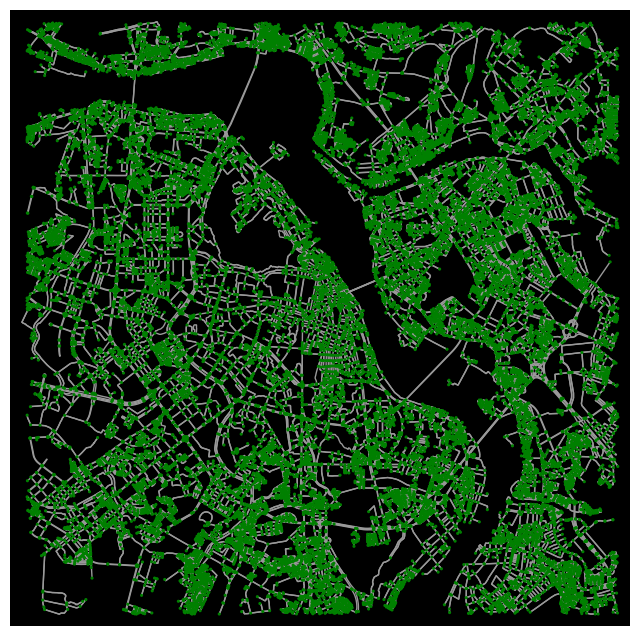

In [28]:
G=ox.graph_from_point(start, dist=10000, network_type="drive")
G=ox.add_edge_speeds(G)
G=ox.add_edge_travel_times(G)
fig,ax = ox.plot_graph(G, bgcolor="black", node_size=5 , node_color="green", figsize=(16,8))

In [29]:
start_node=ox.distance.nearest_nodes(G, start[1], start[0])
dtf["node"]=dtf[["y", "x"]].apply(lambda x: ox.distance.nearest_nodes(G, x[1], x[0]), axis=1)
dtf=dtf.drop_duplicates("node", keep='first')
dtf.head()

/tmp/ipykernel_88870/2197898139.py:2: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipykernel_88870/2197898139.py:2: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipykernel_88870/2197898139.py:2: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipykernel_88870/2197898139.py:2: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (c

,id,City,Street Address,y,x,node
0,0,Hà Nội,01 Lê Duẩn,21.028,105.848,322505394
1,1,Hà Nội,5 Tôn Đức Thắng,21.033,105.834,104833247
2,2,Hà Nội,123 Phan Đình Phùng,21.028,105.841,103060023
4,4,Hà Nội,56 Trần Hưng Đạo,21.029,105.839,103060021
5,5,Hà Nội,55 Hoàng Hoa Thám,21.034,105.823,6641303697


In [30]:
def f(a , b):
    try:
        d=nx.shortest_path_length(G, source=a, target=b, method='dijkstra', weight='travel_time')
    except:
        d=np.nan
    return d

distance_matrix=np.asarray([[f(a,b)for b in dtf["node"].tolist()] for a in dtf["node"].tolist()])
distance_matrix=pd.DataFrame(distance_matrix, columns=dtf["node"].values, index=dtf["node"].values)

distance_matrix.head()

,322505394,104833247,103060023,103060021,6641303697,98044064,317807041
322505394,0.0,147.3,86.4,97.2,213.0,85.6,38.7
104833247,166.9,0.0,104.0,114.8,78.8,103.2,150.2
103060023,163.3,115.6,0.0,10.8,181.3,99.6,152.9
103060021,152.5,104.8,89.6,0.0,170.5,88.8,142.1
6641303697,296.5,181.4,233.6,244.4,0.0,232.8,286.1


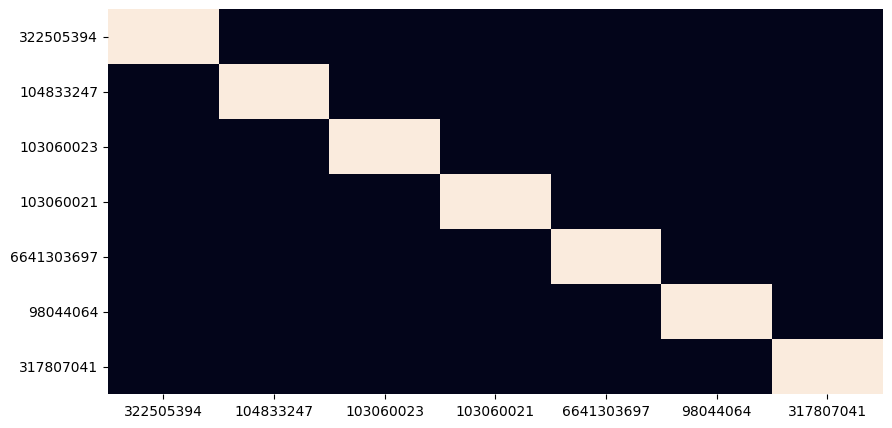

In [31]:
heatmap= distance_matrix.copy()
for col in heatmap.columns:
    heatmap[col]=heatmap[col].apply(lambda x: 
         0.3 if pd.isnull(x) else
         (0.7 if np.isinf(x) else 
          (0 if x!=0 else 1)) )
    
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(heatmap, vmin=0 , vmax=1 , cbar=False, ax=ax)
plt.show()

In [32]:
distance_matrix= distance_matrix.round()
distance_matrix=distance_matrix.astype('int')
distance_matrix

,322505394,104833247,103060023,103060021,6641303697,98044064,317807041
322505394,0,147,86,97,213,86,39
104833247,167,0,104,115,79,103,150
103060023,163,116,0,11,181,100,153
103060021,152,105,90,0,171,89,142
6641303697,297,181,234,244,0,233,286
98044064,86,154,62,73,219,0,76
317807041,64,118,56,66,183,55,0


In [33]:
drivers = 1 
lst_nodes= dtf["node"].tolist()
print("start:", start_node, "total locations to visit", len(lst_nodes)-1, "drivers", drivers)

start: 322505394 total locations to visit 6 drivers 1


In [34]:
manager= pywrapcp.RoutingIndexManager(len(lst_nodes), drivers, lst_nodes.index(start_node))
model=pywrapcp.RoutingModel(manager)

In [35]:
def get_distance(from_index, to_index):
    return distance_matrix.iloc[from_index, to_index]

distance=model.RegisterTransitCallback(get_distance)
model.SetArcCostEvaluatorOfAllVehicles(distance)

parameters = pywrapcp.DefaultRoutingSearchParameters()
parameters.first_solution_strategy= (routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

In [36]:
solution= model.SolveWithParameters(parameters)

index=model.Start(0)
print('route for driver:')
route_idx, route_distance = [], 0

while not model.IsEnd(index):
    route_idx.append(manager.IndexToNode(index))
    previous_index=index
    index=solution.Value(model.NextVar(index))
    
    try:
        route_distance +=get_distance(previous_index, index)
    except:
        route_distance+=model.GetArcCostForVehicle(from_index=previous_index, to_index=index, vehicle=0)
        
print(route_idx)
print(f'Total distance:{round(route_distance/1000,2)}km')
print(f'Nodes visited: {len(route_idx)}')

route for driver:
[0, 5, 6, 2, 3, 1, 4]
Total distance:0.41km
Nodes visited: 7


In [37]:
print("Route for driver (nodes):")
lst_route=[lst_nodes[i] for i in route_idx]
print(lst_route)

Route for driver (nodes):
[322505394, 98044064, 317807041, 103060023, 103060021, 104833247, 6641303697]


In [38]:
def get_path_between_nodes(lst_route):
    lst_paths=[]
    for i in range (len(lst_route)):
        try :
            a , b = lst_nodes[i], lst_nodes[i+1]
        except:
            break
        try:
            path=nx.shortest_path(G, source=a, target=b, method ='dijkstra', weight='travel_time')
            if len(path) > 1:
                lst_paths.append(path)
        except:
            continue
    return lst_paths

lst_paths= get_path_between_nodes(lst_route)

for path in lst_paths:
    ox.plot_route_folium(G, route=path, route_map=map, color="green", weight=1)
    
map

/tmp/ipykernel_88870/1040511094.py:19: FutureWarning:

The `folium` module has been deprecated and will be removed in the v2.0.0 release. You can generate and explore interactive web maps of graph nodes, edges, and/or routes automatically using GeoPandas.GeoDataFrame.explore instead, for example like: `ox.graph_to_gdfs(G, nodes=False).explore()`. See the OSMnx examples gallery for complete details and demonstrations.

/tmp/ipykernel_88870/1040511094.py:19: FutureWarning:

The `folium` module has been deprecated and will be removed in the v2.0.0 release. You can generate and explore interactive web maps of graph nodes, edges, and/or routes automatically using GeoPandas.GeoDataFrame.explore instead, for example like: `ox.graph_to_gdfs(G, nodes=False).explore()`. See the OSMnx examples gallery for complete details and demonstrations.

/tmp/ipykernel_88870/1040511094.py:19: FutureWarning:

The `folium` module has been deprecated and will be removed in the v2.0.0 release. You can generate a

In [39]:
def df_animation_multiple_path(G, lst_paths, parallel=True):
    df=pd.DataFrame()
    for path in lst_paths :
        lst_start, lst_end = [] , []
        start_x, start_y = [] , []
        end_x, end_y = [], []
        lst_length, lst_time = [], [] 
        
        for a , b in zip (path[:-1], path[1:]):
            lst_start.append(a)
            lst_end.append(b)
            lst_length.append(round(G.edges[(a,b,0)]['length']))
            lst_time.append(round(G.edges[(a,b,0)]['travel_time']))
            start_x.append(G.nodes[a]['x'])
            start_y.append(G.nodes[a]['y'])
            end_x.append(G.nodes[b]['x'])
            end_y.append(G.nodes[b]['y'])
            
        tmp=pd.DataFrame(list(zip(lst_start, lst_end, start_x, start_y, end_x, end_y, lst_length, lst_time)), 
                         columns= ["start", "end", "start_x", "start_y", "end_x", "end_y", "length", "travel_time"])
        df=pd.concat([df,tmp], ignore_index=(not parallel))
        
    df=df.reset_index().rename(columns={"index":"id"})
    return df
            

In [40]:
df= pd.DataFrame()
tmp=df_animation_multiple_path(G, lst_paths, parallel=False)
df=pd.concat([df, tmp], axis=0)
first_node, last_node= lst_paths[0][0], lst_paths[-1][-1]

In [41]:
df_start= df[df["start"]== first_node]
df_end=df[df["end"]== last_node]

fig=px.scatter_mapbox(data_frame=df, lon="start_x", lat="start_y", zoom=15, width=900, height=700, animation_frame="id",mapbox_style="carto-positron")

fig.data[0].marker={"size":12}

fig.add_trace(px.scatter_mapbox(data_frame=dtf, lon="x", lat="y").data[0])
fig.data[1].marker={"size":10, "color":"black"}

fig.add_trace(px.scatter_mapbox(data_frame=df_start, lon="start_x", lat="start_y").data[0])
fig.data[2].marker={"size":15, "color":"red"}

fig.add_trace(px.scatter_mapbox(data_frame=df_end, lon="start_x", lat="start_y").data[0])
fig.data[3].marker={"size":15, "color":"green"}

fig.add_trace(px.line_mapbox(data_frame=df, lon="start_x", lat="start_y").data[0])

fig

